<h4><b>DATASET STATISTICS</b></h4>

<b>Importing libraries</b>

In [118]:
import warnings
import sys
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from src.main.utilities.utils import get_dataset
from src.main.pipeline.pipeline import Pipeline
from src.main.pipeline.functions import stop_words_removal, clean_text, remove_contractions, unify_numbers, tfidf_vectorizer

from wordcloud import WordCloud
from collections import Counter
from yellowbrick.text import TSNEVisualizer
import seaborn as sns
from scipy.interpolate import interp1d

warnings.filterwarnings('ignore')
current_dir = %pwd

parent_dir = os.path.abspath(os.path.join(current_dir, '../..'))
sys.path.append(parent_dir)

#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

<b>Number of sample per class</b>

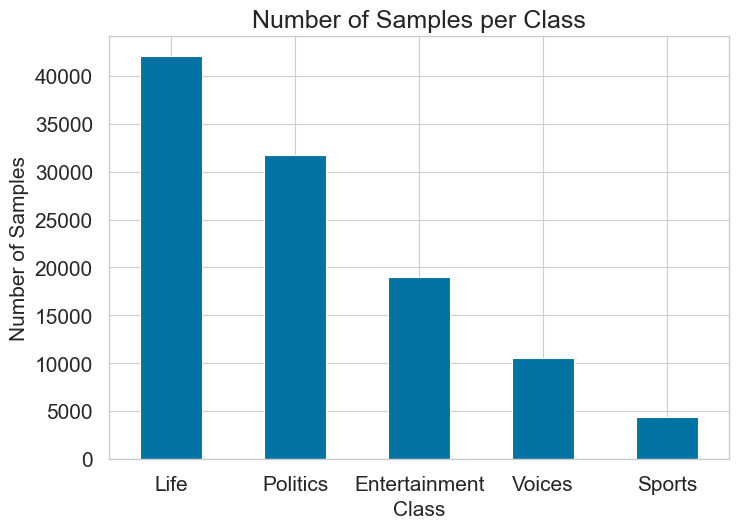

In [119]:
inputs, targets = get_dataset()
targets_series = pd.Series(targets)
class_counts = targets_series.value_counts()

class_counts.plot(kind='bar')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.title('Number of Samples per Class', fontsize=18)
plt.xticks(rotation='horizontal') 
plt.show()


In [120]:
pipeline = Pipeline([remove_contractions, clean_text, stop_words_removal])
inputs, targets = get_dataset()
results = pipeline.execute(inputs)

Pipeline started
Pipeline execution time: 0:00:22.396425


<b>Plot in mean how many words are removed after applying the pipeline for each class</b>

0.0


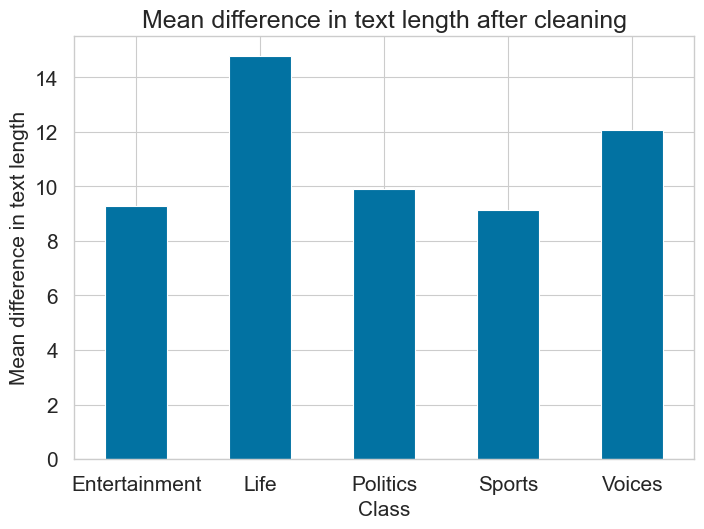

In [121]:
text_lengths = [len(text.split()) for text in results.reshape(-1).tolist()]
clean_text_lengths = [len(text.split()) for text in results.flatten()]
print(np.mean(text_lengths) - np.mean(clean_text_lengths))

dataframe = pd.DataFrame({'full_article': inputs.reshape(-1).tolist(), 'class': targets})

dataframe['clean_text'] = results
dataframe['text_length'] = dataframe['full_article'].apply(lambda x: len(x.split()))
dataframe['clean_text_length'] = dataframe['clean_text'].apply(lambda x: len(x.split()))
dataframe['text_length_diff'] = dataframe['text_length'] - dataframe['clean_text_length']
dataframe['class'] = targets
dataframe.groupby('class')['text_length_diff'].mean()

dataframe.groupby('class')['text_length_diff'].mean().plot(kind='bar')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Class', fontsize=15)
plt.ylabel('Mean difference in text length', fontsize=15)
plt.title('Mean difference in text length after cleaning', fontsize=18)
plt.xticks(rotation='horizontal') 
plt.show()




<b>Plot of document lengths distributions without pipeline applied</b>

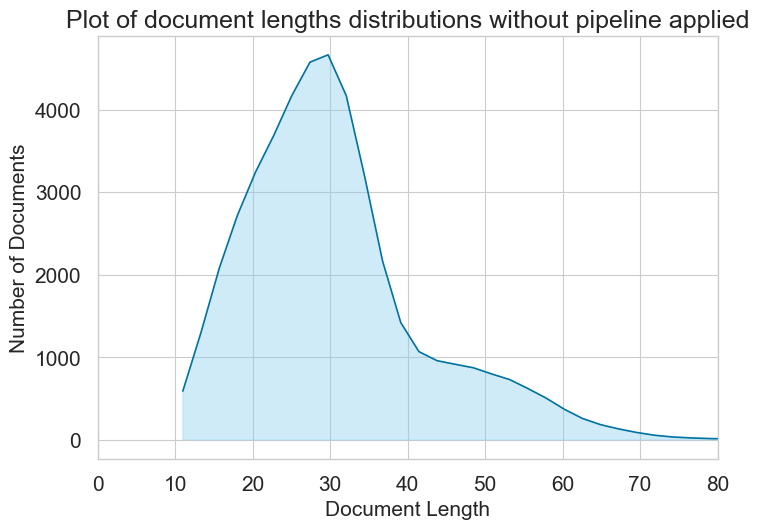

In [122]:
document_lengths = [len(text.split()) for text in inputs.reshape(-1).tolist()]

document_lengths_count = {}
for length in document_lengths:
    if length in document_lengths_count:
        document_lengths_count[length] += 1
    else:
        document_lengths_count[length] = 1


sns.set_style('whitegrid')
sns.set_context('paper')


x = list(document_lengths_count.keys())
y = list(document_lengths_count.values())

x_interp = np.linspace(min(x), max(x), 100)
y_interp = interp1d(x, y, kind='cubic')(x_interp)
y_interp = np.convolve(y_interp, np.ones(3)/3, mode='same')

plt.fill_between(x_interp, y_interp, color='skyblue', alpha=0.4)
sns.lineplot(x=x_interp, y=y_interp)
plt.xlim(0, 80)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Document Length', fontsize=15)
plt.ylabel('Number of Documents', fontsize=15)
plt.title('Plot of document lengths distributions without pipeline applied', fontsize=18)
plt.show()


<b>Plot of document lengths distributions with the pipeline applied</b>

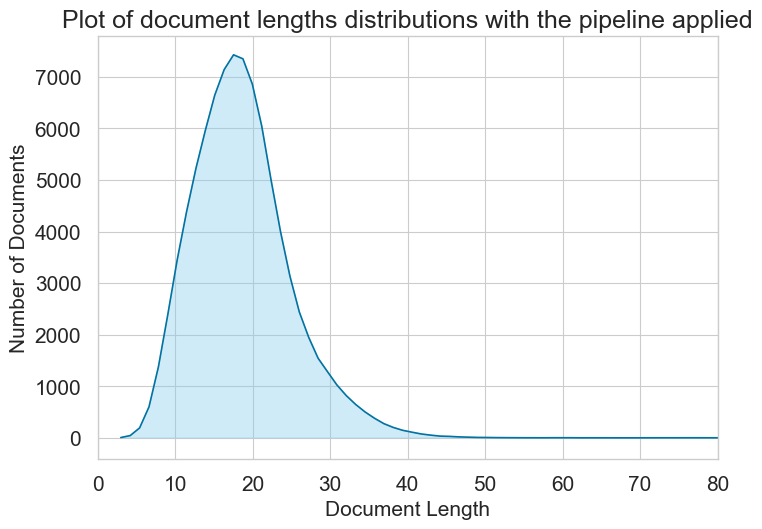

In [123]:
document_lengths = [len(text.split()) for text in results.reshape(-1).tolist()]

document_lengths_count = {}
for length in document_lengths:
    if length in document_lengths_count:
        document_lengths_count[length] += 1
    else:
        document_lengths_count[length] = 1

sns.set_style('whitegrid')
sns.set_context('paper')
#max_iter_interp = max_iter_interp[:len(max_iter_interp)]
x = list(document_lengths_count.keys())
y = list(document_lengths_count.values())

x_interp = np.linspace(min(x), max(x), 100)
y_interp = interp1d(x, y, kind='cubic')(x_interp)
y_interp = np.convolve(y_interp, np.ones(3)/3, mode='same')

plt.fill_between(x_interp, y_interp, color='skyblue', alpha=0.4)
sns.lineplot(x=x_interp, y=y_interp)
plt.xlim(0, 80)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Document Length', fontsize=15)
plt.ylabel('Number of Documents', fontsize=15)
plt.title('Plot of document lengths distributions with the pipeline applied', fontsize=18)
plt.show()

<b>Plot of mean and standard deviation of document's length for each class </b>

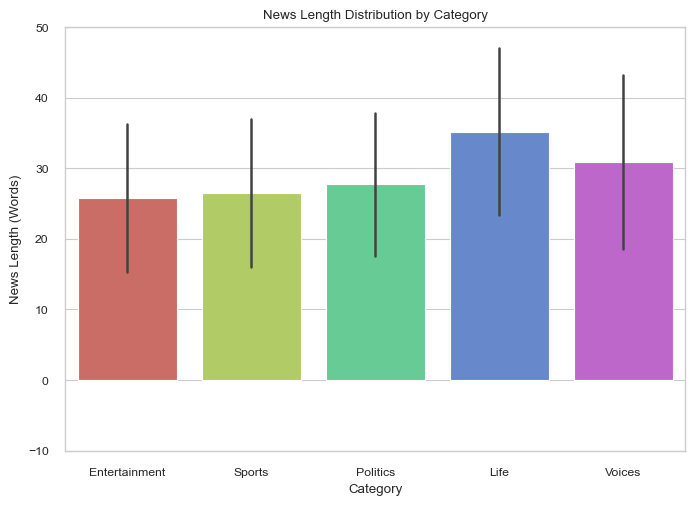

In [124]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'dataframe' and has columns 'article' and 'category'
# Calculate news length (assuming length is the number of words in the article)
dataframe['category'] = targets
dataframe['length'] = dataframe['full_article'].str.split().str.len()

def plot_bars_with_variance(df, category_col, value_col):
  """
  Plots a bar chart with colors and adjusted y-axis scale.

  Args:
      df (pandas.DataFrame): The DataFrame containing the data.
      category_col (str): The name of the column containing the category values.
      value_col (str): The name of the column containing the values for which to plot the distribution.
  """
  # Generate a color palette for the number of categories
  palette = sns.color_palette("hls", len(df[category_col].unique()))

  # Plot bar chart with color and y-axis limits
  sns.barplot(x=category_col, y=value_col, data=df, errorbar="sd", palette=palette, hue=category_col)  
  plt.ylim(-10, 50)  # Set y-axis limits between -50 and 50

  # Customize plot (remove legend for variances)
  plt.xlabel('Category')
  plt.ylabel('News Length (Words)')
  plt.title('News Length Distribution by Category')
  
  plt.show()

# Call the plotting function
plot_bars_with_variance(dataframe.copy(), 'category', 'length')

<b>Plot a word cloud for each class</b>

In [125]:
pipeline = Pipeline([remove_contractions, clean_text, stop_words_removal]) # unify_numbers removed -> generate [NUM] tokens
inputs, targets = get_dataset()
results = pipeline.execute(inputs)

Pipeline started
Pipeline execution time: 0:00:01.862191


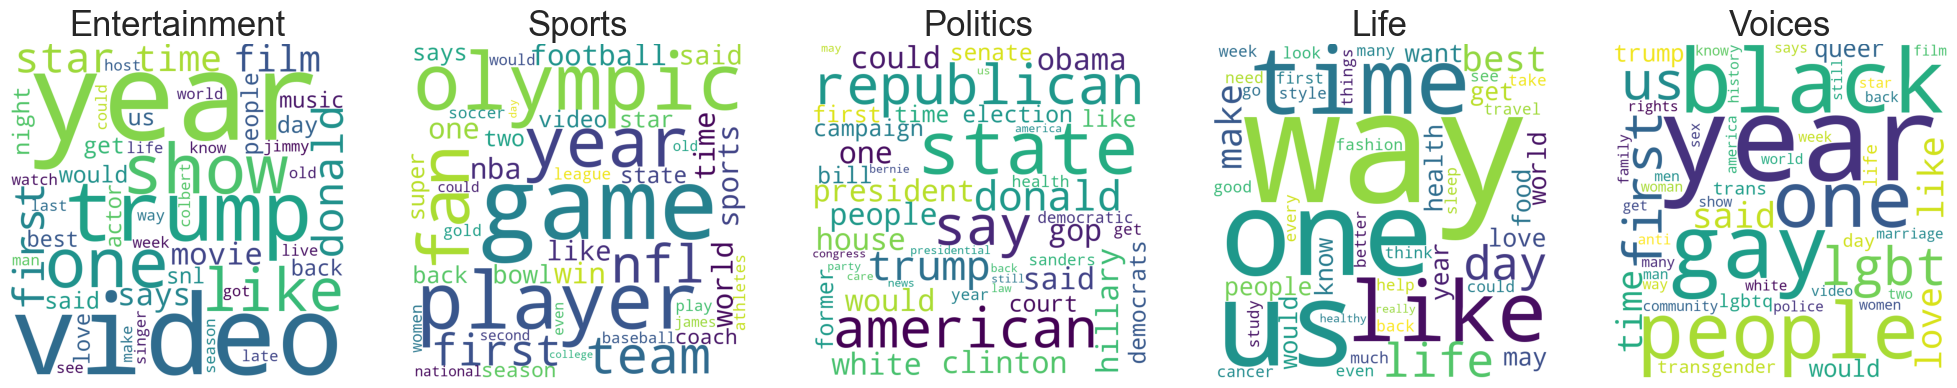

In [126]:
custom_stopwords = ['new', 'num']

dict = {}
for i in range(len(targets)):
    if targets[i] in dict:
        dict[targets[i]] += results[i].item().split()
    else:
        dict[targets[i]] = results[i].item().split()

for key in dict:
    dict[key] = Counter(dict[key]).most_common(50)



fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i, key in enumerate(dict):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = custom_stopwords, 
                min_font_size = 10).generate(' '.join([word[0] for word in dict[key]]))
    axs[i].imshow(wordcloud)
    axs[i].axis("off")
    axs[i].set_title(key, fontsize=25)
plt.show()



<b>t-distributed Stochastic Neighbor Embedding plots</b>

In [127]:
pipeline = Pipeline([
    remove_contractions,
    clean_text,
    stop_words_removal,
    unify_numbers,
    tfidf_vectorizer
])

inputs, targets = get_dataset()

df = pd.DataFrame({'full_article': inputs.reshape(-1), 'label': targets})
df = df.groupby(targets).head(1000)
df = df[df['label'] != 'Voices']
inputs = df['full_article'].values
targets = df['label'].values
results = pipeline.execute(inputs).reshape(-1)[0]  # [0] to get the sparse matrix

Pipeline started
Pipeline execution time: 0:00:00.145364


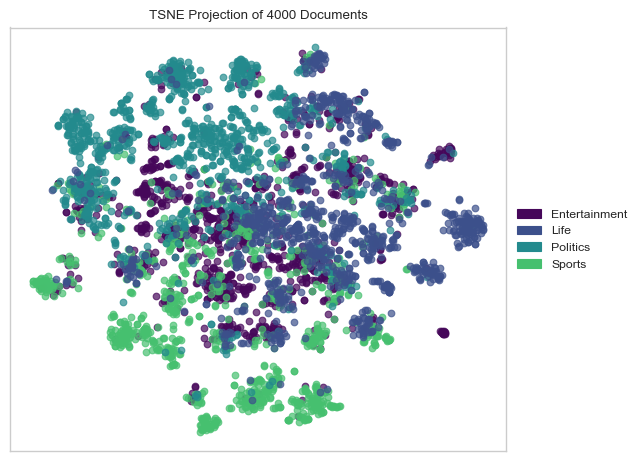

<Axes: title={'center': 'TSNE Projection of 4000 Documents'}>

In [128]:
palette = sns.color_palette("viridis", 60)
selected_colors = [palette[0], palette[14], palette[28], palette[42], palette[56]]
tsne = TSNEVisualizer(colors=selected_colors)#colormap='viridis')
tsne.fit(results, targets)
tsne.show()